In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.utils import shuffle

import keras


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [3]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

#### Here, we are just setting the Y and X from the training dataset. 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

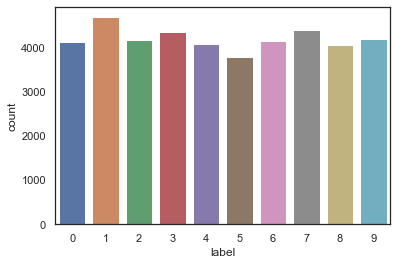

In [4]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

sns.countplot(Y_train)

Y_train.value_counts()

#### Performing GrayScale Normalization

In [5]:
X_train = X_train / 255.0
test = test / 255.0

In [6]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [7]:
Y_train = to_categorical(Y_train, num_classes = 10)

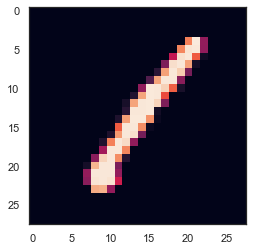

In [8]:
g = plt.imshow(X_train[0][:,:,0])

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

### Building my own model + Data Augmentation

#### Data Augmentation is the process of changing or adding noise to image. This could be rotating, or shifting the images. Essentially adding noise allows for the data to be better prepared. We have to be careful with some image augmentation process such as rotation as this can cause confusion between the numbers 6 and 9. Here context means a lot. 

In [10]:
# A helper function to create augmentation of images
def augmentImages(images, multiple):
    gen = ImageDataGenerator()
    newImages = []
    for _ in range(multiple):
        for image in images:
            transformedImage = gen.apply_transform(image, {'brightness': np.random.uniform(low = 0.5, high=0.99),
                                                            'tx': np.random.random_integers(2),
                                                            'ty': np.random.random_integers(2)})
            newImages.append(transformedImage)
    newImages = np.array(newImages)
    return newImages

### Deep Learning Model

#### In special cases such as image detection we have a base layer, (which soles purpose is to detect features in an image). These are the layers with Conv2D and MaxPoooling2D. These layers extract certain features from the data.

#### The convolution filters an image. The activation relu is used to detect that feature with in the filtered image. Finally, maxpooling condenses the image layer to enhance the features. 

#### The 3 step as summarized are:

##### 1. Conv2D -> Convolutions (Filters the image)

##### 2. Relu -> Detect feature

##### 3. MaxPooling2D -> Enhances the features

#### For this project I'm going to experiment with different model to see how performance would vary.

In [27]:
model = Sequential()

# Base: This is where we apply the 3 feature detection steps above
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(128,(2,2), activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Head: Thisi s where we identify the class of the image
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [16]:
model2 = Sequential()

# Base: This is where we apply the 3 feature detection steps above
model2.add(Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
model2.add(Conv2D(32, (2,2), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.3))


# Head: Thisi s where we identify the class of the image
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(10, activation='softmax'))

In [17]:
model3 = Sequential()

# Base: This is where we apply the 3 feature detection steps above
model3.add(Conv2D(8, (2,2), activation='relu', input_shape=(28,28,1)))
model3.add(Conv2D(16, (2,2), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(32, (2,2), activation='relu'))
model3.add(Conv2D(64,(2,2), activation ='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

# Head: Thisi s where we identify the class of the image
model3.add(Flatten())
model3.add(Dense(100, activation='relu'))
model3.add(Dense(10, activation='softmax'))

#### After defining the model, the next step is to compile and define optimizers. These include the loss functions and optimizers. The loss function defines how the model should be trained. The optimizers are the ways the model will use to improve it's loss function. We also have metrics = ['accuracy] which essentially is a parameters that tells the model to print the accuracy every epoch iteration.

In [29]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=2)

model.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

model2.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

model3.compile(optimizer=keras.optimizers.SGD(1e-3),
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

In [19]:
newNumbers = augmentImages([X_train[0]],1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  if __name__ == '__main__':


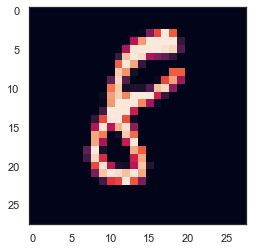

In [20]:
plt.imshow(newNumbers.reshape(28,28))

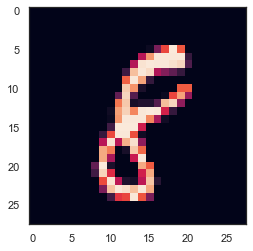

In [21]:
plt.imshow(X_train[0].reshape(28,28))

In [22]:
augmentPic = augmentImages(X_train,1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  if __name__ == '__main__':


#### Shuffling the data is always good practice! 

In [23]:
x_train, y_train = shuffle(X_train, Y_train)

In [30]:
model.fit(x_train, y_train, batch_size = 32, epochs=50, validation_split=0.4, callbacks=[early_stopping_monitor])


Train on 22680 samples, validate on 15120 samples
Epoch 1/50
22680/22680 [==============================] - 25s 1ms/step - loss: 2.2921 - accuracy: 0.1395 - val_loss: 2.2769 - val_accuracy: 0.3238
Epoch 2/50
22680/22680 [==============================] - 24s 1ms/step - loss: 2.2549 - accuracy: 0.2618 - val_loss: 2.2186 - val_accuracy: 0.5608
Epoch 3/50
22680/22680 [==============================] - 25s 1ms/step - loss: 2.0751 - accuracy: 0.4570 - val_loss: 1.6993 - val_accuracy: 0.6722
Epoch 4/50
22680/22680 [==============================] - 24s 1ms/step - loss: 1.1081 - accuracy: 0.6663 - val_loss: 0.6230 - val_accuracy: 0.8243
Epoch 5/50
22680/22680 [==============================] - 25s 1ms/step - loss: 0.7057 - accuracy: 0.7713 - val_loss: 0.4919 - val_accuracy: 0.8552
Epoch 6/50
22680/22680 [==============================] - 24s 1ms/step - loss: 0.6062 - accuracy: 0.8028 - val_loss: 0.4458 - val_accuracy: 0.8630
Epoch 7/50
22680/22680 [==============================] - 25s 1ms/s

In [31]:
model2.fit(x_train, y_train, batch_size = 32, epochs=50, validation_split=0.4, callbacks=[early_stopping_monitor])

Train on 22680 samples, validate on 15120 samples
Epoch 1/50
22680/22680 [==============================] - 15s 652us/step - loss: 2.1478 - accuracy: 0.3758 - val_loss: 1.8073 - val_accuracy: 0.7001
Epoch 2/50
22680/22680 [==============================] - 14s 635us/step - loss: 1.1882 - accuracy: 0.7339 - val_loss: 0.6183 - val_accuracy: 0.8449
Epoch 3/50
22680/22680 [==============================] - 14s 631us/step - loss: 0.5790 - accuracy: 0.8302 - val_loss: 0.4327 - val_accuracy: 0.8749
Epoch 4/50
22680/22680 [==============================] - 14s 632us/step - loss: 0.4686 - accuracy: 0.8572 - val_loss: 0.3658 - val_accuracy: 0.8956
Epoch 5/50
22680/22680 [==============================] - 14s 633us/step - loss: 0.4181 - accuracy: 0.8727 - val_loss: 0.3353 - val_accuracy: 0.9021
Epoch 6/50
22680/22680 [==============================] - 14s 636us/step - loss: 0.3852 - accuracy: 0.8800 - val_loss: 0.3197 - val_accuracy: 0.9042
Epoch 7/50
22680/22680 [==============================] 

In [32]:
model3.fit(x_train, y_train, batch_size = 32, epochs=50, validation_split=0.4, callbacks=[early_stopping_monitor])

Train on 22680 samples, validate on 15120 samples
Epoch 1/50
22680/22680 [==============================] - 12s 530us/step - loss: 2.2899 - accuracy: 0.1257 - val_loss: 2.2724 - val_accuracy: 0.2415
Epoch 2/50
22680/22680 [==============================] - 11s 498us/step - loss: 2.2510 - accuracy: 0.2008 - val_loss: 2.2144 - val_accuracy: 0.4601
Epoch 3/50
22680/22680 [==============================] - 11s 502us/step - loss: 2.1103 - accuracy: 0.3650 - val_loss: 1.8895 - val_accuracy: 0.6401
Epoch 4/50
22680/22680 [==============================] - 11s 492us/step - loss: 1.4076 - accuracy: 0.5772 - val_loss: 0.8528 - val_accuracy: 0.7540
Epoch 5/50
22680/22680 [==============================] - 11s 492us/step - loss: 0.9343 - accuracy: 0.6881 - val_loss: 0.6288 - val_accuracy: 0.8134
Epoch 6/50
22680/22680 [==============================] - 11s 493us/step - loss: 0.7776 - accuracy: 0.7407 - val_loss: 0.5466 - val_accuracy: 0.8378
Epoch 7/50
22680/22680 [==============================] 

#### It's interesting to see that the second model only took 34 epochs compared to the first and third model. This model has more layers instead of more neurons in a single layers. 

#### Now, for each model we are going to see the accuracy

In [33]:
score = model.evaluate(X_val, Y_val, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 0.0726565051362628
Test accuracy 0.9783333539962769


In [34]:
score = model2.evaluate(X_val, Y_val, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 0.22555871427059174
Test accuracy 0.9316666722297668


In [35]:
score = model3.evaluate(X_val, Y_val, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 0.11865282896019164
Test accuracy 0.9638095498085022
